## Neural Networks for Music Classification

In [4]:
#Loading Tensorflow
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# Audio Feature Extraction with Librosa
import librosa
import librosa.display
import librosa.feature

import requests

In [3]:
fn = "SopSax.Vib.pp.C6Eb6.aiff"
url = "http://theremin.music.uiowa.edu/sound files/MIS/Woodwinds/sopranosaxophone/"+fn

#Load the file from url and save it in a file under the name fn
req = requests.get(url, stream=True)
with open(fn, 'wb') as f:
    for chunk in req.iter_content(chunk_size=1024): 
        f.write(chunk)  

In [4]:
y, sr = librosa.load(fn)   #"/Users/Barr/Downloads/SopSax.Vib.pp.C6Eb6.aiff")

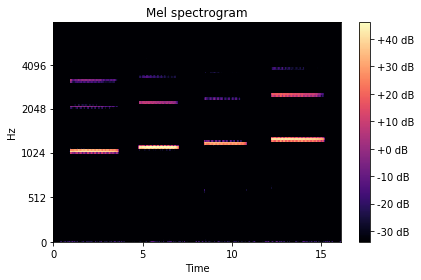

In [5]:
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
librosa.display.specshow(librosa.amplitude_to_db(S),
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

In [6]:
# Downloading the Data

data_dir = '/Users/Barr/Documents/instrument_dataset/'
Xtr = np.load(data_dir+'uiowa_train_data.npy')
ytr = np.load(data_dir+'uiowa_train_labels.npy')
Xts = np.load(data_dir+'uiowa_test_data.npy')
yts = np.load(data_dir+'uiowa_test_labels.npy')

In [7]:
Xtr_size=Xtr.shape[0]
Xts_size=Xts.shape[0]
feat=Xts.shape[1]
classes=np.max(ytr)+1

print(f'Xtr size = {Xtr_size}, Xts size = {Xts_size}')
print(f'#features = {feat}, #classes = {classes}')

Xtr size = 66247, Xts size = 14904
#features = 120, #classes = 10


In [8]:
#Scaling
xtr_m=np.mean(Xtr, axis=0)
xtr_s=np.std(Xtr, axis=0)
Xtr=(Xtr-xtr_m)/xtr_s
Xts=(Xts-xtr_m)/xtr_s

In [9]:
# Building a Neural Network Classifier
#-------------------------------------
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Activation
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers

In [10]:
K.clear_session() #clear session

In [11]:
#Construct the model
nin = Xtr.shape[1]  # dimension of input data
nh = 256     # number of hidden units
nout = int(np.max(ytr)+1)    # number of outputs = 10 since there are 10 classes
model = Sequential()
model.add(Dense(units=nh, input_shape=(nin,), activation='sigmoid', name='hidden'))
model.add(Dense(units=nout, activation='softmax', name='output'))

Instructions for updating:
Colocations handled automatically by placer.


In [12]:
model.summary() #Print the model summary

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 256)               30976     
_________________________________________________________________
output (Dense)               (None, 10)                2570      
Total params: 33,546
Trainable params: 33,546
Non-trainable params: 0
_________________________________________________________________


In [13]:
#Create an optimizer and compile
from tensorflow.keras import optimizers

opt = optimizers.Adam(lr=0.001) 
model.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [14]:
#Fit the model for 10 epochs, batch size of 100 using callback
hist = model.fit(Xtr, ytr, epochs=10, batch_size=100, validation_data=(Xts,yts))

Train on 66247 samples, validate on 14904 samples
Epoch 1/10
66247/66247 [==============================] - 3s 42us/sample - loss: 0.3697 - acc: 0.8983 - val_loss: 0.2182 - val_acc: 0.9267
Epoch 2/10
66247/66247 [==============================] - 2s 33us/sample - loss: 0.1065 - acc: 0.9742 - val_loss: 0.0933 - val_acc: 0.9789
Epoch 3/10
66247/66247 [==============================] - 2s 35us/sample - loss: 0.0620 - acc: 0.9848 - val_loss: 0.0709 - val_acc: 0.9808
Epoch 4/10
66247/66247 [==============================] - 2s 36us/sample - loss: 0.0436 - acc: 0.9892 - val_loss: 0.0508 - val_acc: 0.9865
Epoch 5/10
66247/66247 [==============================] - 2s 34us/sample - loss: 0.0328 - acc: 0.9914 - val_loss: 0.0406 - val_acc: 0.9893
Epoch 6/10
66247/66247 [==============================] - 2s 35us/sample - loss: 0.0262 - acc: 0.9931 - val_loss: 0.0328 - val_acc: 0.9908
Epoch 7/10
66247/66247 [==============================] - 2s 36us/sample - loss: 0.0212 - acc: 0.9943 - val_loss: 0.

Text(0, 0.5, 'accuarcy')

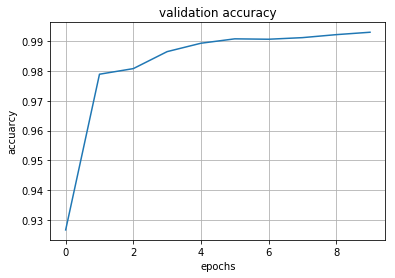

In [15]:
val_accuracy = hist.history['val_acc']

plt.plot(val_accuracy)
plt.grid()
plt.title('validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuarcy')

Text(0, 0.5, 'accuarcy')

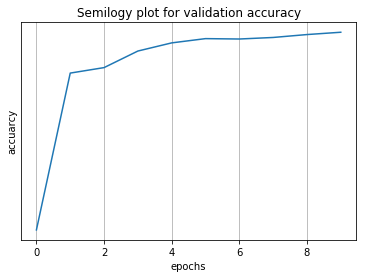

In [19]:
val_accuracy = hist.history['val_acc']

plt.semilogy(val_accuracy)
plt.grid()
plt.title('Semilogy plot for validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuarcy')

Text(0, 0.5, 'loss')

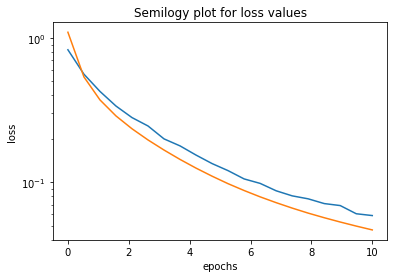

In [32]:
val_loss = hist.history['val_loss']
tr_loss=hist.history['loss']
epochs=np.linspace(0,10,len(val_loss))

plt.semilogy(epochs, val_loss)
plt.semilogy(epochs, tr_loss)
#plt.grid()
plt.title('Semilogy plot for loss values')
plt.xlabel('epochs')
plt.ylabel('loss')

In [20]:
# Optimizing the Learning Rate
# ----------------------------

rates = [0.01,0.001,0.0001]
batch_size = 100
loss_hist = []
acc_hist = []

for lr in rates:
    K.clear_session() #clear session
    model = Sequential()
    model.add(Dense(units=nh, input_shape=(nin,), activation='sigmoid', name='hidden'))
    model.add(Dense(units=nout, activation='softmax', name='output'))
    opt = optimizers.Adam(lr=lr) 
    model.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    hist = model.fit(Xtr, ytr, epochs=20, batch_size=batch_size, validation_data=(Xts,yts))
    loss_hist.append(hist.history['val_loss'])
    acc_hist.append(hist.history['val_acc'])

Train on 66247 samples, validate on 14904 samples
Epoch 1/20
66247/66247 [==============================] - 3s 41us/sample - loss: 0.1097 - acc: 0.9661 - val_loss: 0.0503 - val_acc: 0.9825
Epoch 2/20
66247/66247 [==============================] - 2s 33us/sample - loss: 0.0300 - acc: 0.9902 - val_loss: 0.0392 - val_acc: 0.9862
Epoch 3/20
66247/66247 [==============================] - 2s 36us/sample - loss: 0.0205 - acc: 0.9930 - val_loss: 0.0573 - val_acc: 0.9793
Epoch 4/20
66247/66247 [==============================] - 2s 34us/sample - loss: 0.0195 - acc: 0.9937 - val_loss: 0.0384 - val_acc: 0.9852
Epoch 5/20
66247/66247 [==============================] - 2s 34us/sample - loss: 0.0171 - acc: 0.9946 - val_loss: 0.0370 - val_acc: 0.9858
Epoch 6/20
66247/66247 [==============================] - 2s 33us/sample - loss: 0.0146 - acc: 0.9953 - val_loss: 0.0322 - val_acc: 0.9899
Epoch 7/20
66247/66247 [==============================] - 2s 33us/sample - loss: 0.0117 - acc: 0.9961 - val_loss: 0.

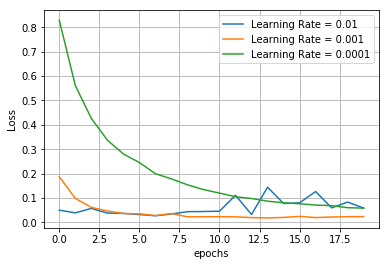

In [21]:
plt.plot(loss_hist[0])
plt.plot(loss_hist[1])
plt.plot(loss_hist[2])
plt.grid()
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend(['Learning Rate = 0.01', 'Learning Rate = 0.001', 'Learning Rate = 0.0001'])

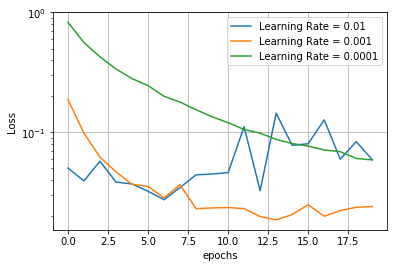

In [33]:
plt.semilogy(loss_hist[0])
plt.semilogy(loss_hist[1])
plt.semilogy(loss_hist[2])
plt.grid()
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend(['Learning Rate = 0.01', 'Learning Rate = 0.001', 'Learning Rate = 0.0001'])